# 1. Create a custom gym environment

In [1]:
from gym import Env
from gym.spaces import Discrete, Box
import os
import numpy as np
import random
import math
from enum import Enum
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [2]:
class Action(Enum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3

In [3]:
class GameEnv(Env):
    def __init__(self, size = 10, mode='static'):
        self.mode = mode
        self.size = size
        self.GAME_LENGTH = 2 * size**2
        self.action_space = Discrete(4)
        self.observation_space = Box(low=0, high=3, shape=(self.size, self.size), dtype=np.int32)
        self.state, self.player, self.goals = self.createBoard()
        self.goals_remaining = len(self.goals)
        self.time_remaining = self.GAME_LENGTH
        self.episode = -1
        #self.make_fig_dir()
        
    def step(self, action):
        self.time_remaining -= 1
        done = False
        
        #evaluate move, save value of the new space before move then update the state
        invalid_move = False
        improved = False
        if Action(action) == Action.UP:
            new_pos = (self.player[0] -1, self.player[1])
            if new_pos[0] >= 0 and self.state[new_pos] != 1:
                new_space_val = self.evalMove(new_pos)
            else:
                invalid_move = True
        elif Action(action) == Action.DOWN:
            new_pos = (self.player[0] +1, self.player[1])
            if new_pos[0] < self.size and self.state[new_pos] != 1:
                new_space_val = self.evalMove(new_pos)
            else:
                invalid_move = True
        elif Action(action) == Action.LEFT:
            new_pos = (self.player[0], self.player[1] -1)
            if new_pos[1] >= 0 and self.state[new_pos] != 1:
                new_space_val= self.evalMove(new_pos)
            else:
                invalid_move = True
        elif Action(action) == Action.RIGHT:
            new_pos = (self.player[0], self.player[1] +1)
            if new_pos[1] < self.size and self.state[new_pos] != 1:
                new_space_val = self.evalMove(new_pos)
            else:
                invalid_move = True
        else:
            print("Invalid input to step function")
            
        #evaluate reward 
        reward = 0
        if invalid_move:
            reward = -0.5
            done = False
        else:
            if new_space_val == 0:
                reward = -0.04
                done = False
            elif new_space_val == 3:
                self.goals_remaining -= 1
                if self.goals_remaining == 0:
                    reward = 20
                    done = True
                else:
                    reward = 20
                    done = False
        
        #evaluate if out of time
        if self.time_remaining == 0:
            done = True
            reward = -20
            
        #placeholder for required return value
        info = {}
        
        return self.state, reward, done, info
    
    def distanceToGoalImproved(self, new_pos):
        distances_before = []
        distances_after = []
        for goal in self.goals:
            distances_before.append(math.sqrt((self.player[0] - goal[0])**2 + (self.player[1] - goal[1])**2))
            distances_after.append(math.sqrt((new_pos[0] - goal[0])**2 + (new_pos[1] - goal[1])**2))
        index_of_closest = distances_before.index(min(distances_before))
        distance_change = distances_after[index_of_closest] - distances_before[index_of_closest]
        if distance_change < 0:
            return True
        return False
    
    def evalMove(self, new_pos):
        new_space_val = self.state[new_pos]
        self.state[self.player] = 0
        self.state[new_pos] = 2
        self.player = new_pos
        return new_space_val
        
    def render(self, mode='human'):
        clear_output(wait=True)
        plt.figure(figsize=(5,5))
        plt.title(f'Clock: {self.time_remaining}, Goals: {self.goals_remaining}')
        plt.axis('off')
        plt.imshow(self.state)
        #if self.episode % 5 == 0:
        #    plt.savefig(f"saved_figs/ep_{self.episode}/{self.GAME_LENGTH - self.time_remaining}_step")
        plt.show()
    
    def make_fig_dir(self):
        cwd = os.getcwd()
        path = os.path.join(cwd,f"saved_figs/ep_{self.episode}")
        os.mkdir(path)

    def reset(self):
        self.state, self.player, self.goals =  self.createBoard()
        self.goals_remaining = len(self.goals)
        self.time_remaining = self.GAME_LENGTH
        self.episode += 1
        #if self.episode % 5 == 0:
        #    self.make_fig_dir()
        return self.state
    
    def createBoard(self):
        board = np.matrix([[1,1,1,1,1,1,1,1,1,1],
                           [1,0,0,0,0,0,0,0,0,1],
                           [1,1,1,0,1,1,1,0,1,1],
                           [1,0,0,0,0,1,0,0,0,1],
                           [1,0,1,1,1,1,0,1,0,1],
                           [1,0,1,1,3,1,0,1,0,1],
                           [1,0,0,0,0,0,0,1,0,1],
                           [1,1,1,0,1,0,1,1,0,1],
                           [1,3,0,0,1,0,0,0,3,1],
                           [1,1,1,1,1,1,1,1,1,1]])
        if self.mode == 'static':
            player_pos = (1,1)
            goals = [(5,5),(8,1),(8,8)]
        elif self.mode == 'random':
            player_pos = (np.random.randint(self.size), np.random.randint(self.size))
            goal_pos = (np.random.randint(self.size), np.random.randint(self.size))
            player_goal_distance = math.sqrt((player_pos[0] - goal_pos[0])**2 + (player_pos[1] - goal_pos[1])**2)
            while player_goal_distance < self.size/2:
                goal_pos = (np.random.randint(self.size), np.random.randint(self.size))
                player_goal_distance = math.sqrt((player_pos[0] - goal_pos[0])**2 + (player_pos[1] - goal_pos[1])**2)
        
        board[player_pos] = 2
        for coord in goals:
            if board[coord] == 0:
                board[coord] = 3
        return board, player_pos, goals

### Test

In [55]:
env = GameEnv()
episodes = 15
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0
    num_moves = 0
    num_backtrack = 0
    while not done:
        action = env.action_space.sample()
        n_state, reward, done, info = env.step(action)
        #if reward == -0.25:
        #    num_backtrack += 1
        if reward == 20:
            print("found one")
        score += reward
        num_moves += 1
        
    print(f'Episode:{episode} Score:{score} Moves:{num_moves} Backtracks:{num_backtrack}')

found one
Episode:1 Score:-53.45999999999992 Moves:200 Backtracks:0
found one
found one
Episode:2 Score:-28.819999999999972 Moves:200 Backtracks:0
found one
found one
Episode:3 Score:-39.399999999999956 Moves:200 Backtracks:0
found one
found one
Episode:4 Score:-30.65999999999994 Moves:200 Backtracks:0
Episode:5 Score:-72.57999999999993 Moves:200 Backtracks:0
found one
found one
Episode:6 Score:-30.199999999999964 Moves:200 Backtracks:0
Episode:7 Score:-73.95999999999992 Moves:200 Backtracks:0
Episode:8 Score:-70.73999999999992 Moves:200 Backtracks:0
found one
Episode:9 Score:-50.69999999999993 Moves:200 Backtracks:0
Episode:10 Score:-71.65999999999991 Moves:200 Backtracks:0
Episode:11 Score:-76.25999999999993 Moves:200 Backtracks:0
Episode:12 Score:-63.83999999999991 Moves:200 Backtracks:0
found one
Episode:13 Score:-50.23999999999993 Moves:200 Backtracks:0
Episode:14 Score:-70.73999999999992 Moves:200 Backtracks:0
Episode:15 Score:-72.57999999999993 Moves:200 Backtracks:0


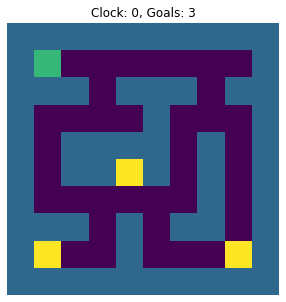

Episode:15 Score:-70.27999999999992


In [56]:
state = env.reset()
done = False
score = 0
while not done:
    action = env.action_space.sample()
    n_state, reward, done, info = env.step(action)
    score += reward
    env.render()

print(f'Episode:{episode} Score:{score}')

# 2. Create Deep Learning Model

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

In [5]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states[0],states[1])))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [10]:
del model
del env

In [11]:
env = GameEnv()
states = env.observation_space.shape
actions = env.action_space.n
model = build_model(states,actions)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               10100     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 20,604
Trainable params: 20,604
Non-trainable params: 0
_________________________________________________________________


# 3. Build Agent

In [7]:
from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, MaxBoltzmannQPolicy, LinearAnnealedPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
#from tf_agents.environments import tf_py_environment

In [8]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=100000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                   nb_actions=actions, nb_steps_warmup=100, target_model_update=1e-2)
    return dqn

In [9]:
#env =  tf_py_environment.TFPyEnvironment(env)

dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=100000, visualize=False, verbose=1)

AttributeError: 'Sequential' object has no attribute '_compile_time_distribution_strategy'

In [16]:
def dqn_tester(dqn, num_eps, vis = False):
    scores = dqn.test(env, nb_episodes=num_eps, visualize=vis)
    print("Mean Reward: " + str(np.mean(scores.history['episode_reward'])))
    #num_win = 0
    #for steps in scores.history['episode_steps']:
    #    if steps < 100:
    #        num_win += 1
    #print(f'Win Rate: {round(num_win/num_eps, 2) * 100}%')

Episode 1: reward: 12.120, steps: 200
Mean Reward: 12.12000000000016


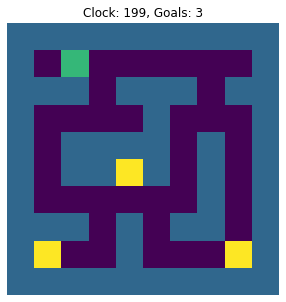

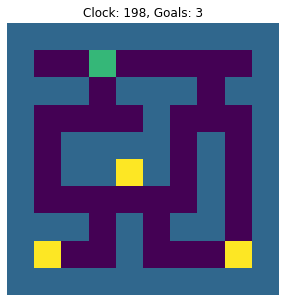

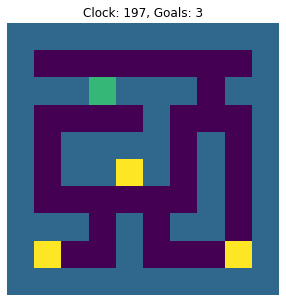

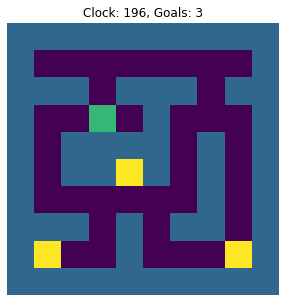

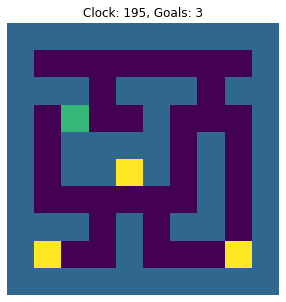

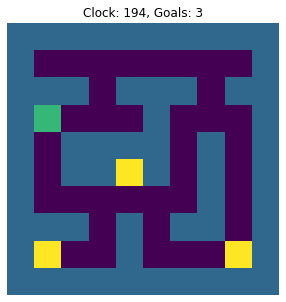

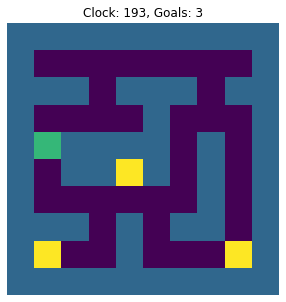

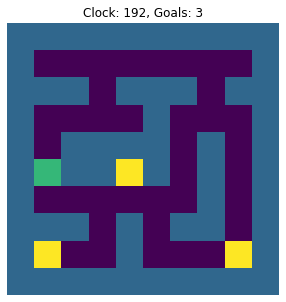

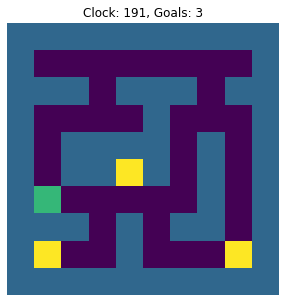

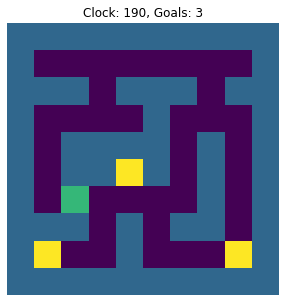

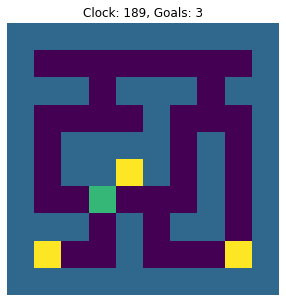

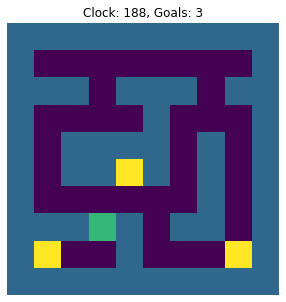

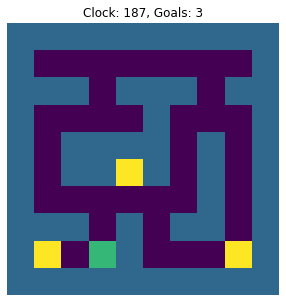

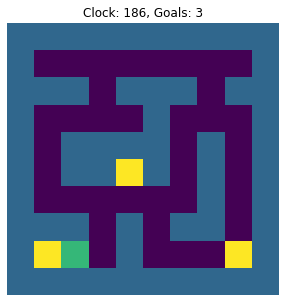

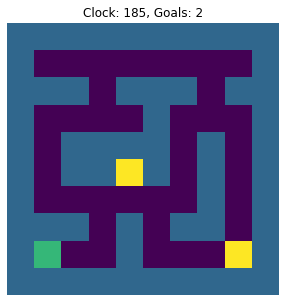

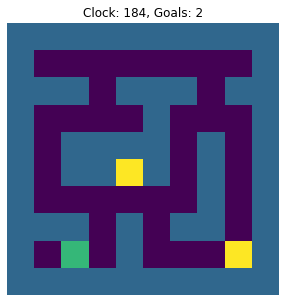

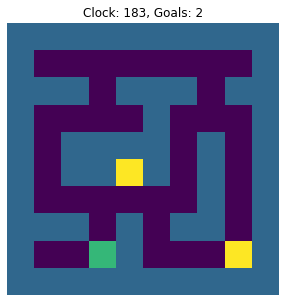

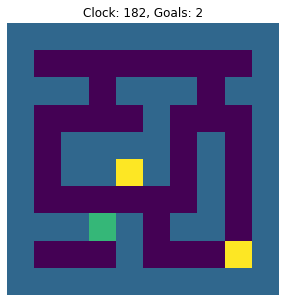

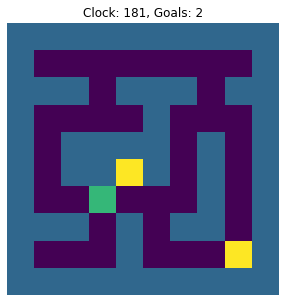

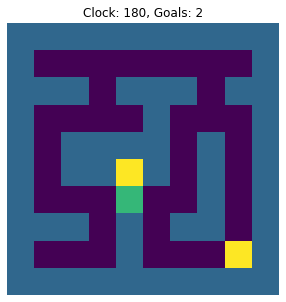

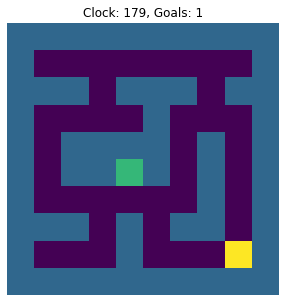

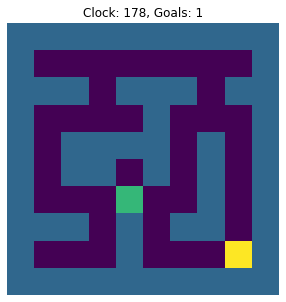

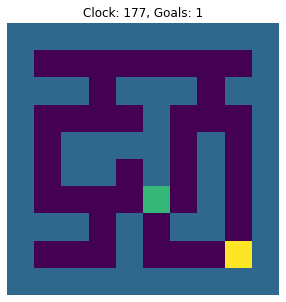

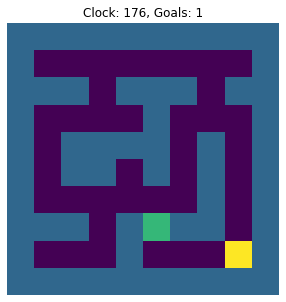

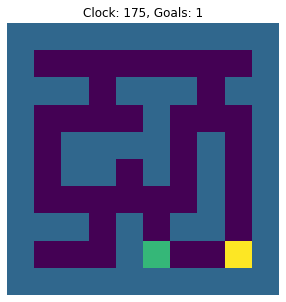

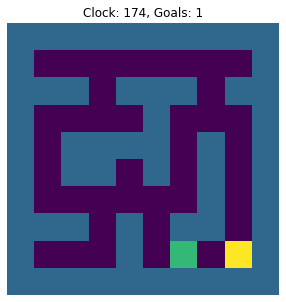

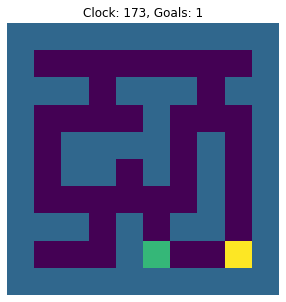

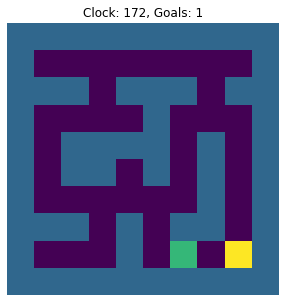

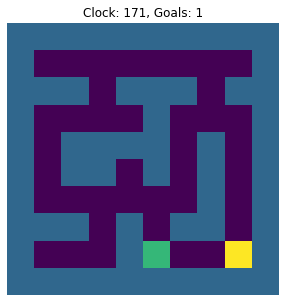

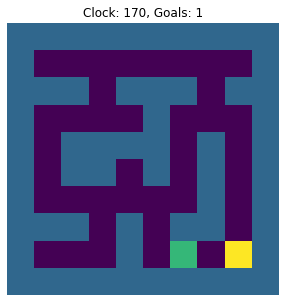

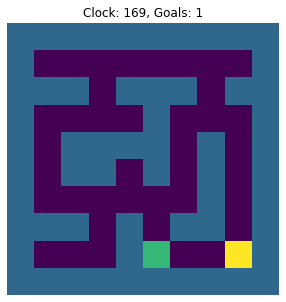

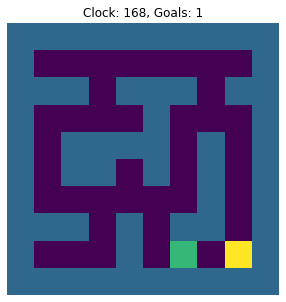

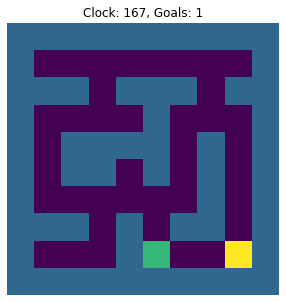

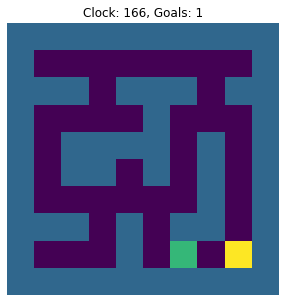

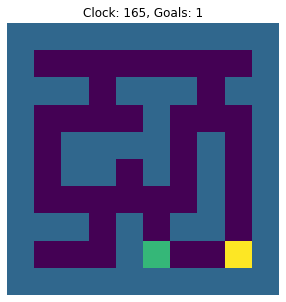

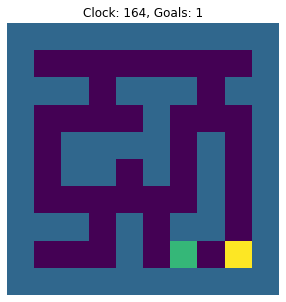

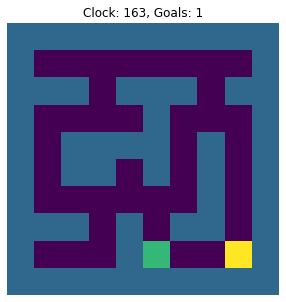

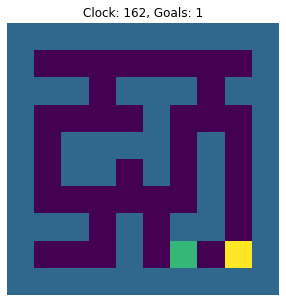

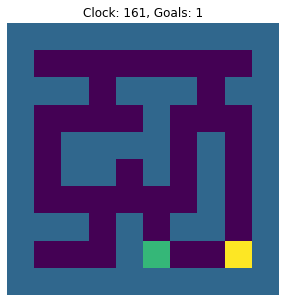

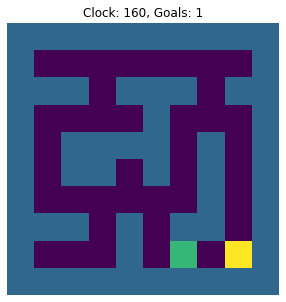

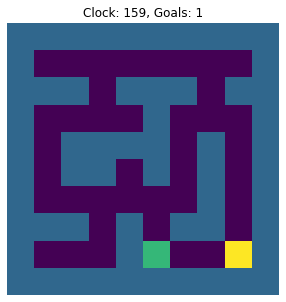

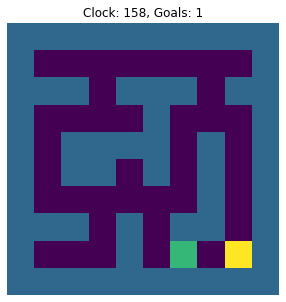

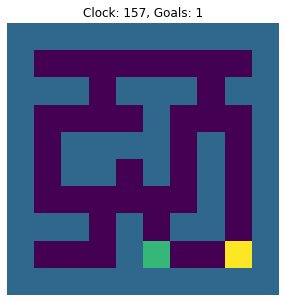

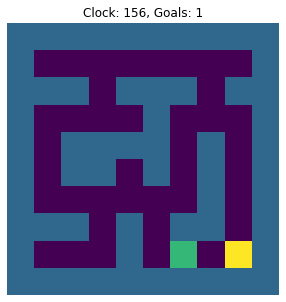

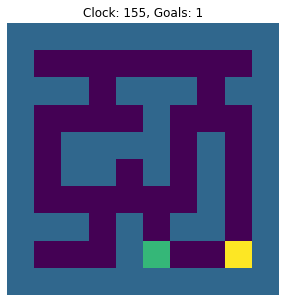

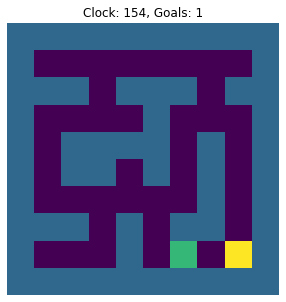

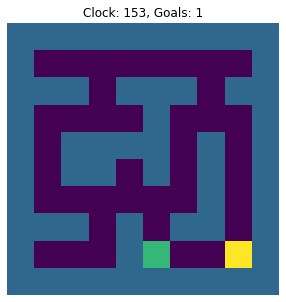

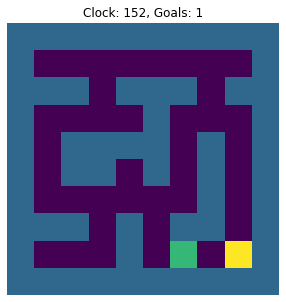

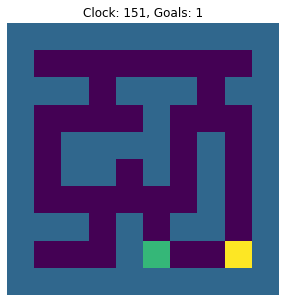

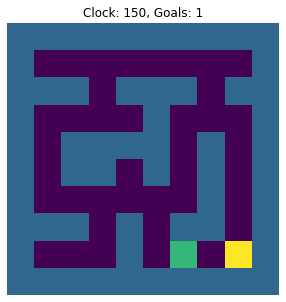

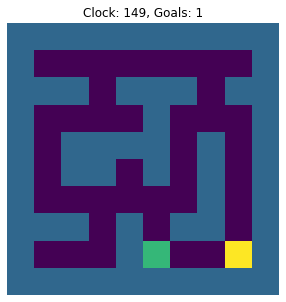

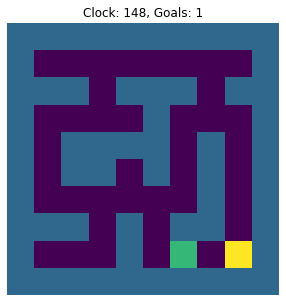

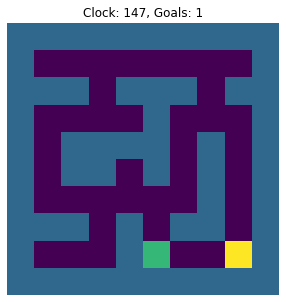

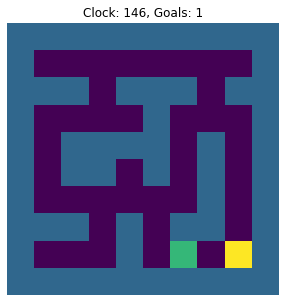

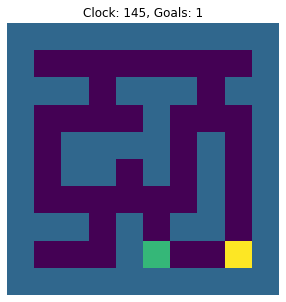

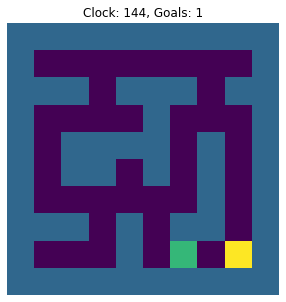

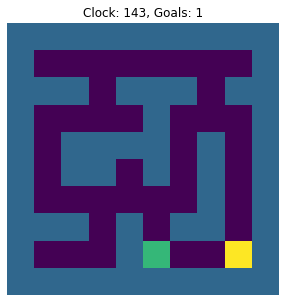

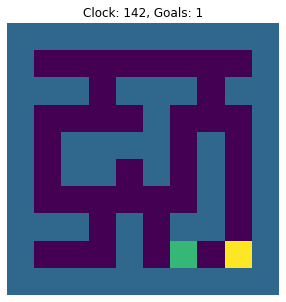

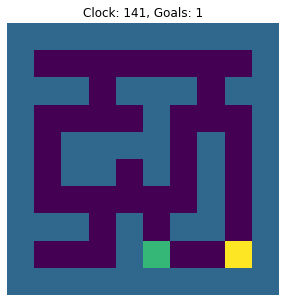

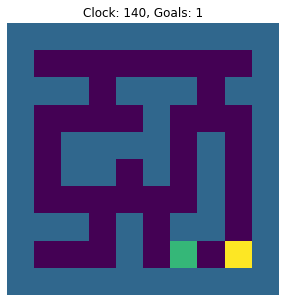

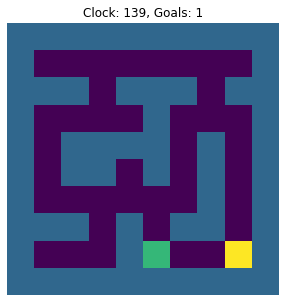

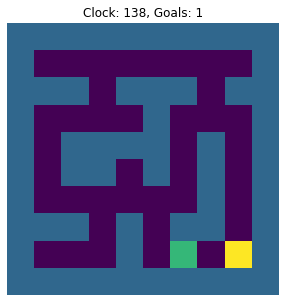

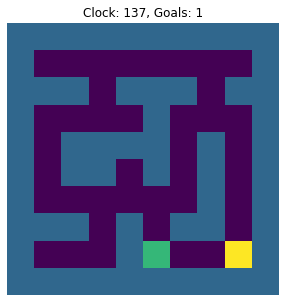

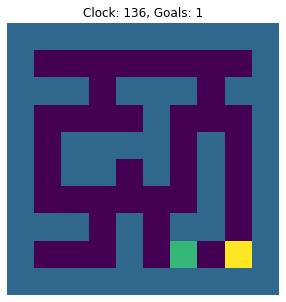

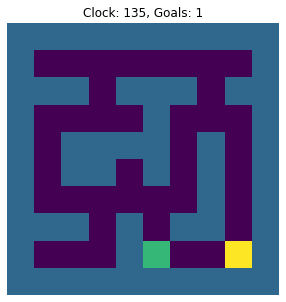

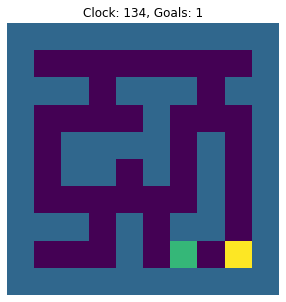

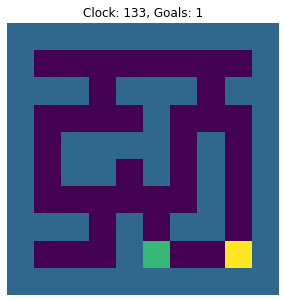

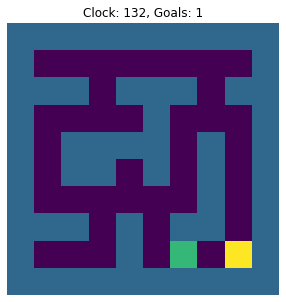

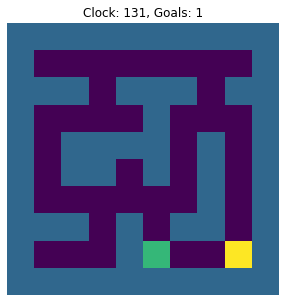

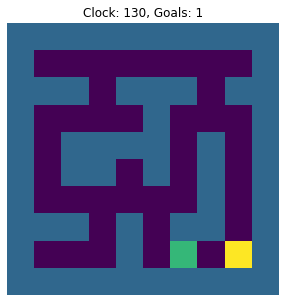

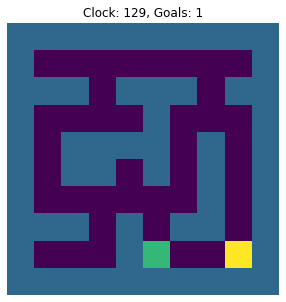

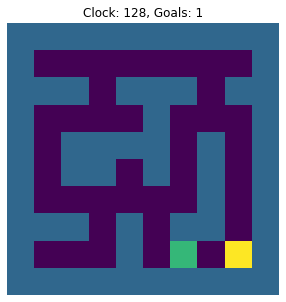

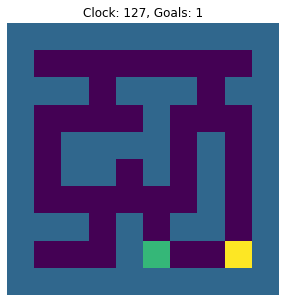

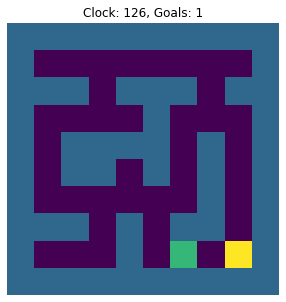

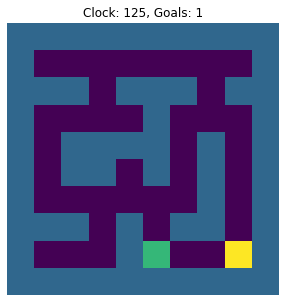

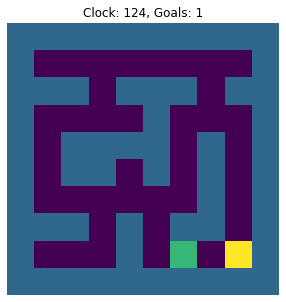

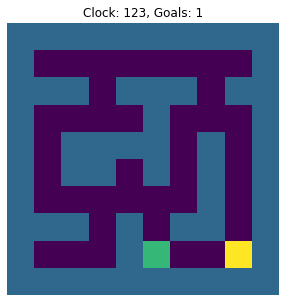

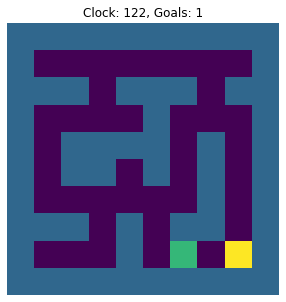

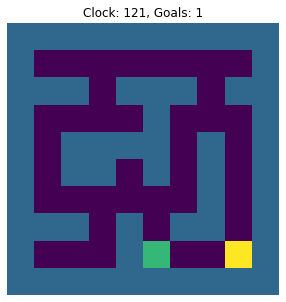

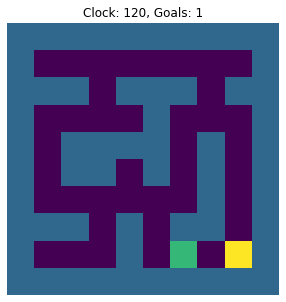

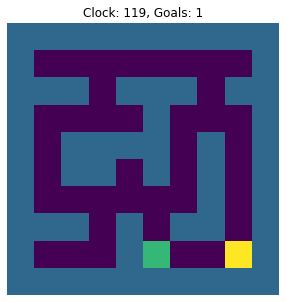

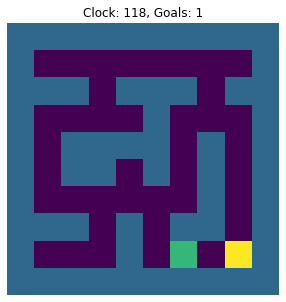

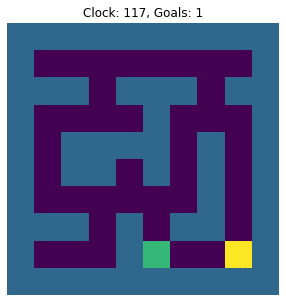

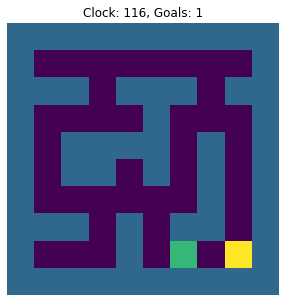

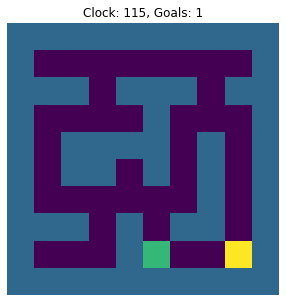

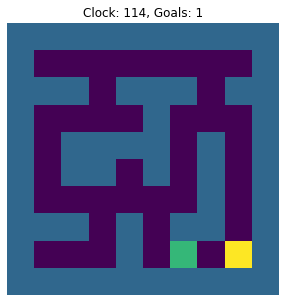

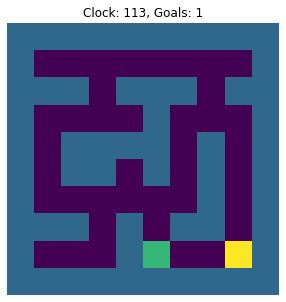

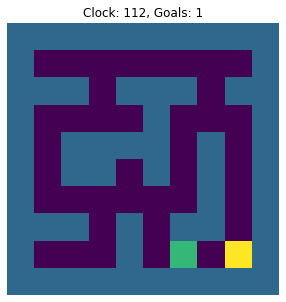

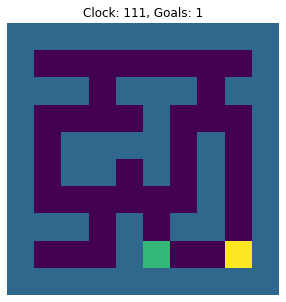

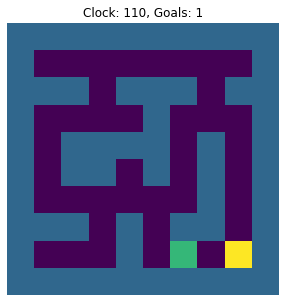

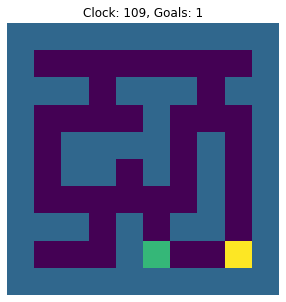

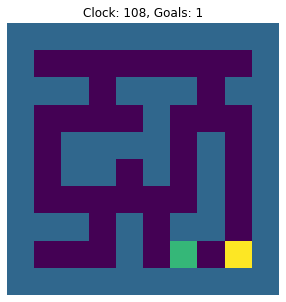

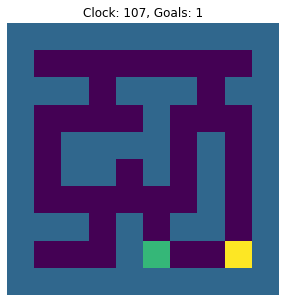

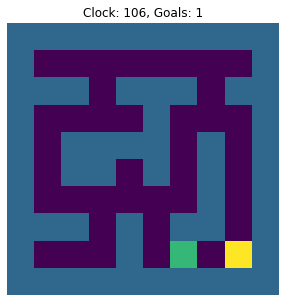

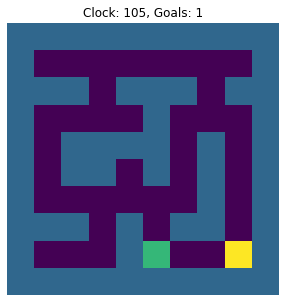

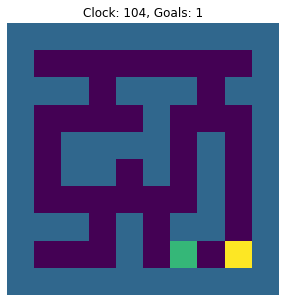

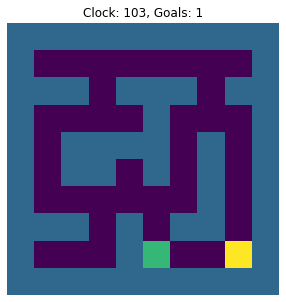

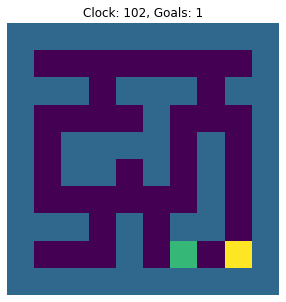

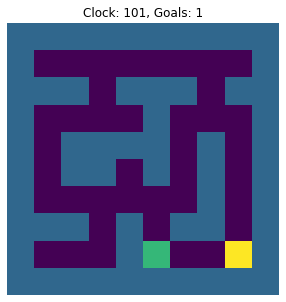

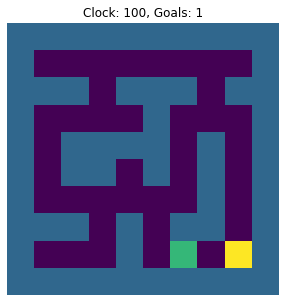

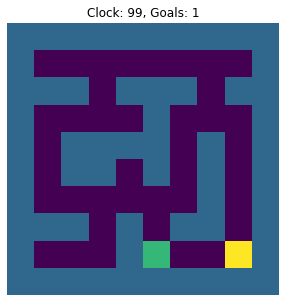

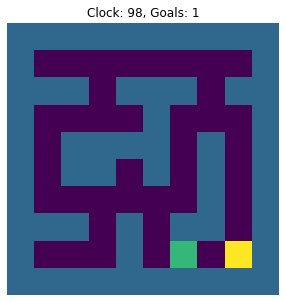

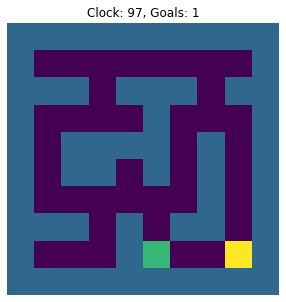

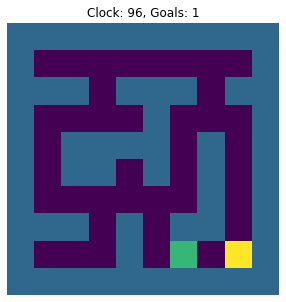

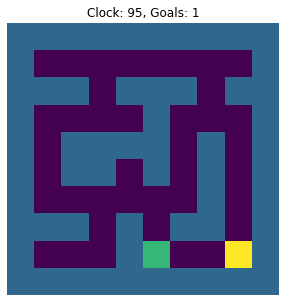

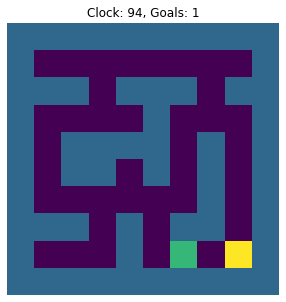

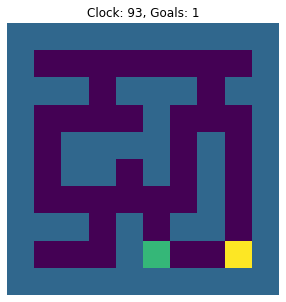

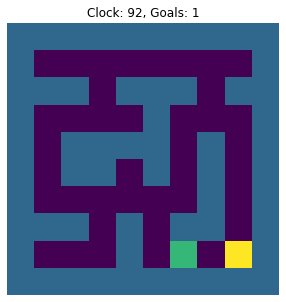

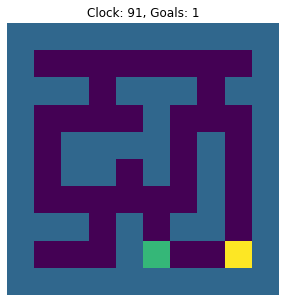

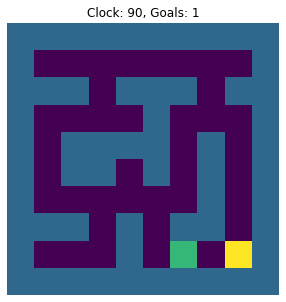

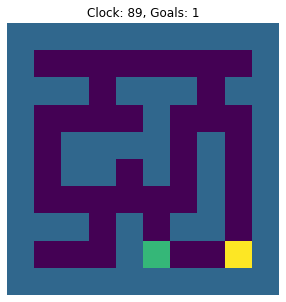

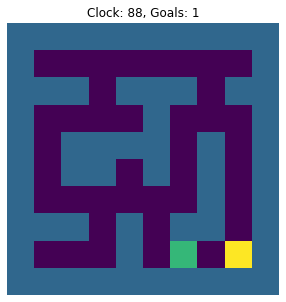

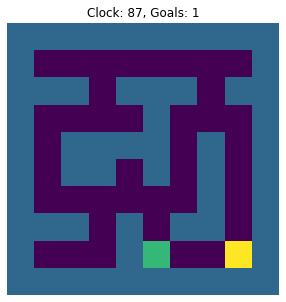

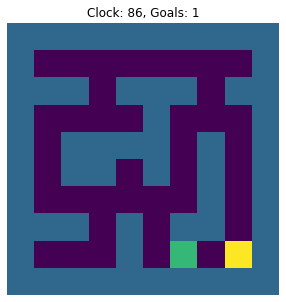

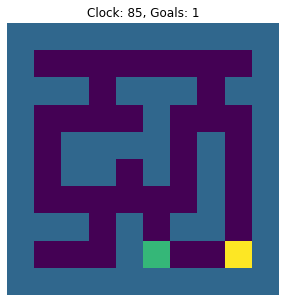

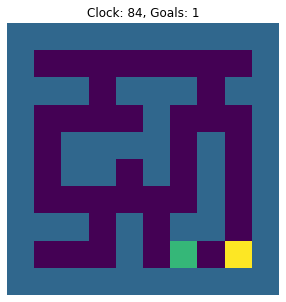

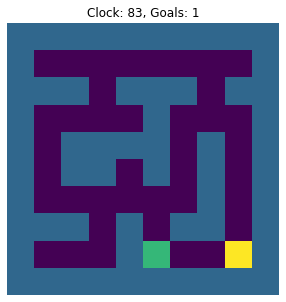

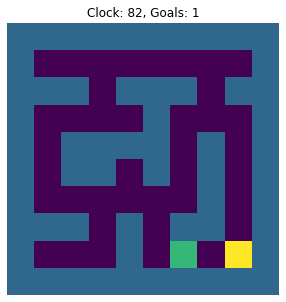

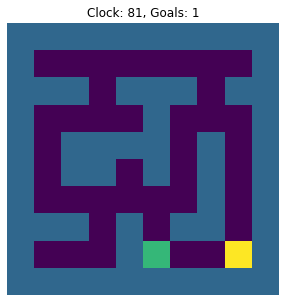

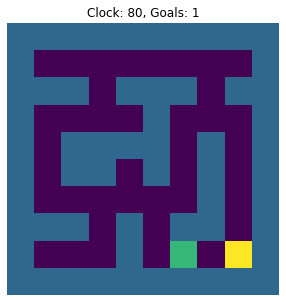

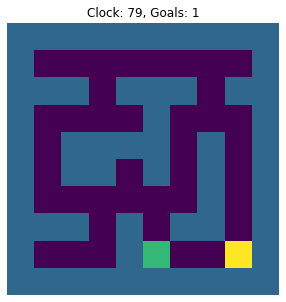

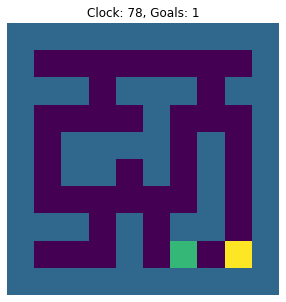

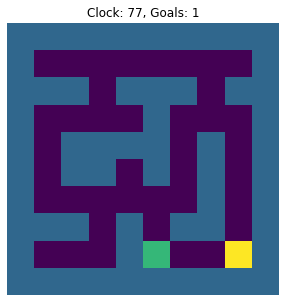

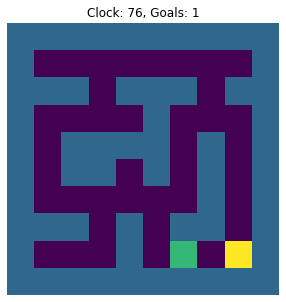

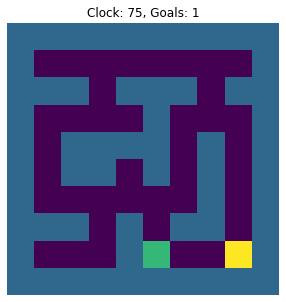

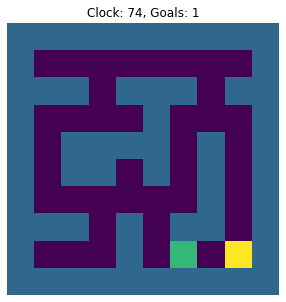

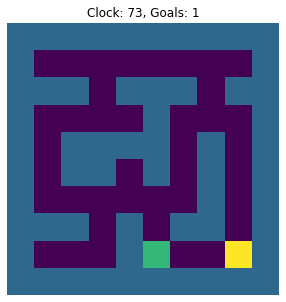

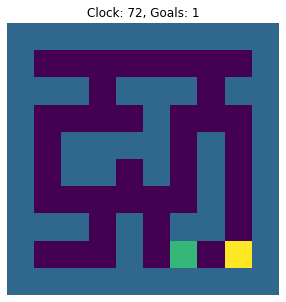

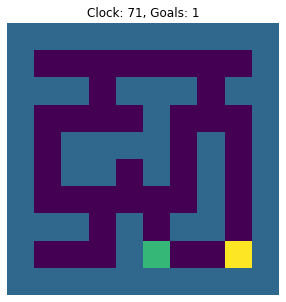

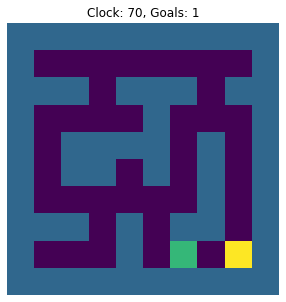

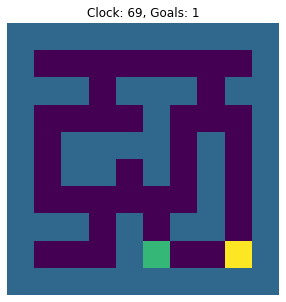

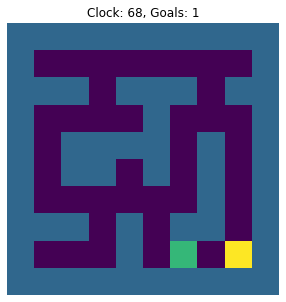

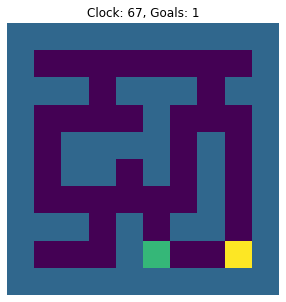

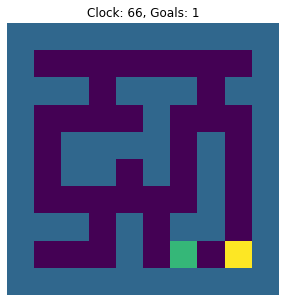

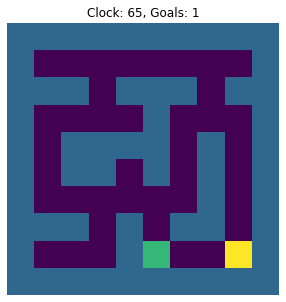

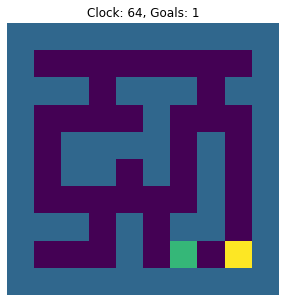

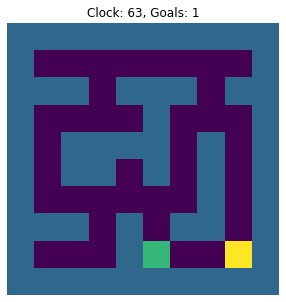

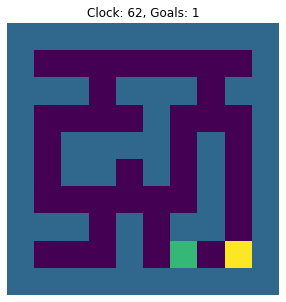

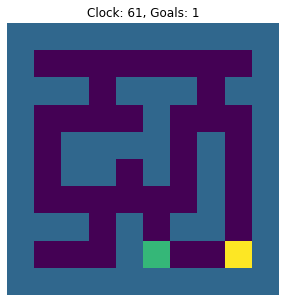

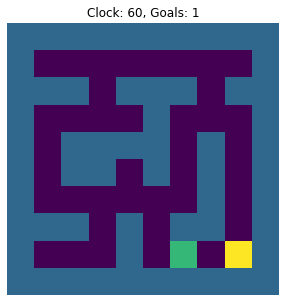

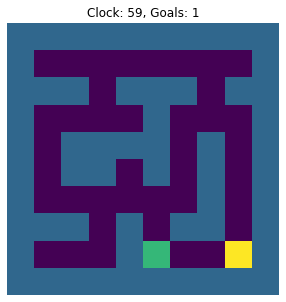

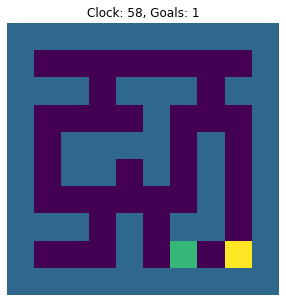

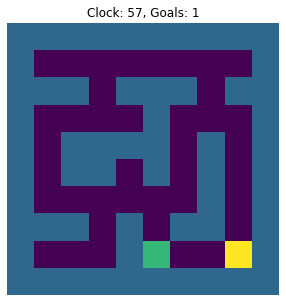

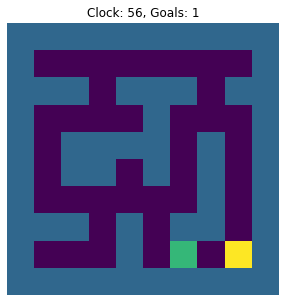

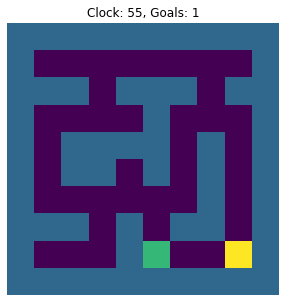

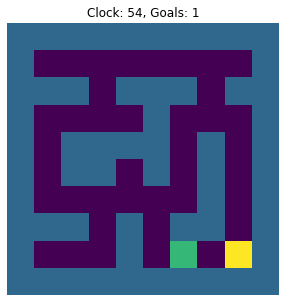

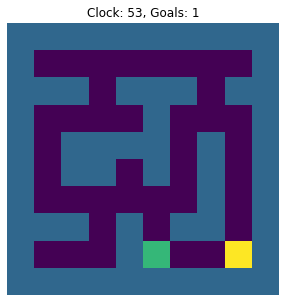

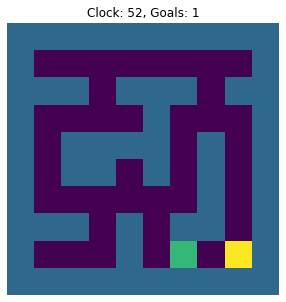

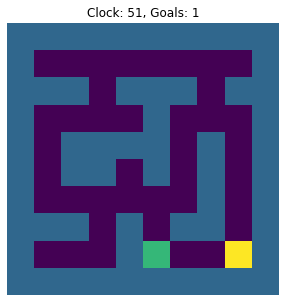

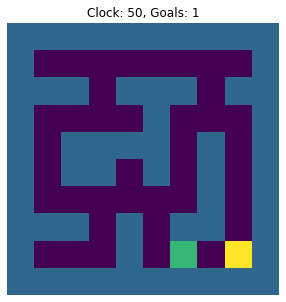

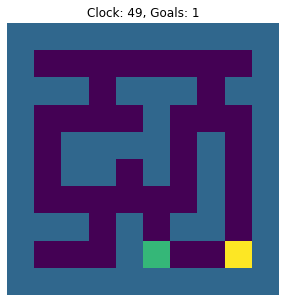

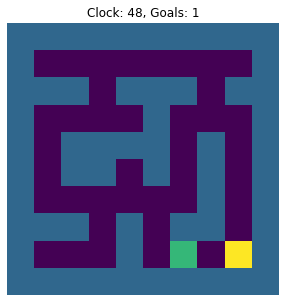

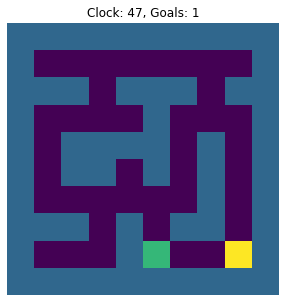

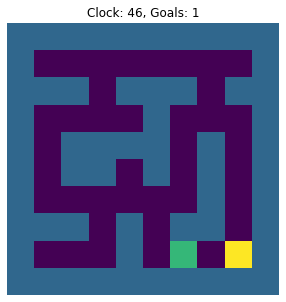

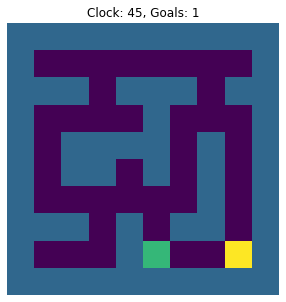

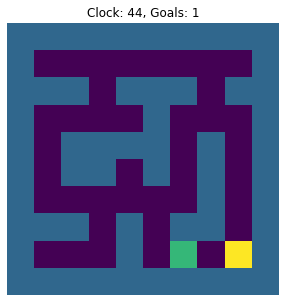

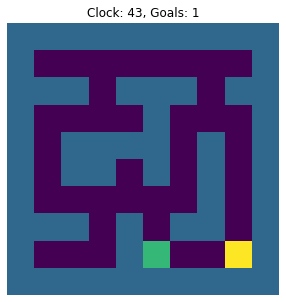

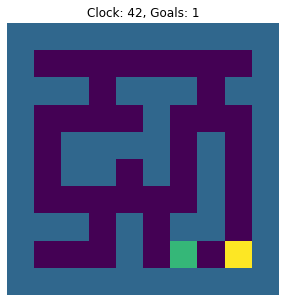

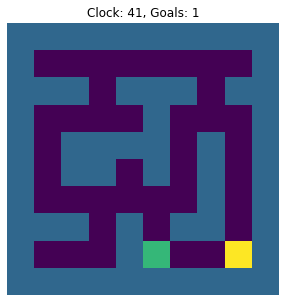

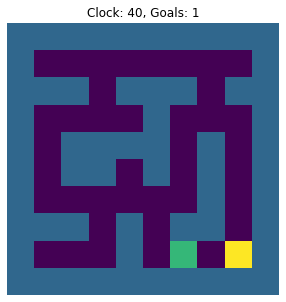

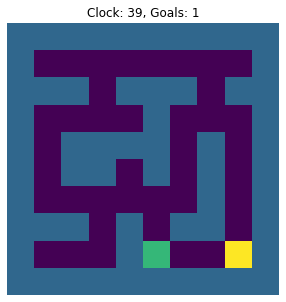

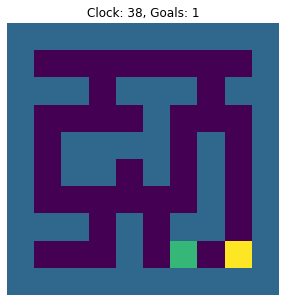

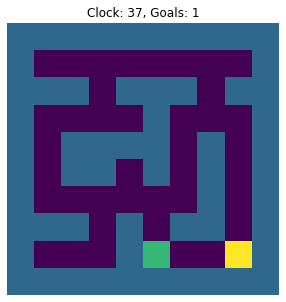

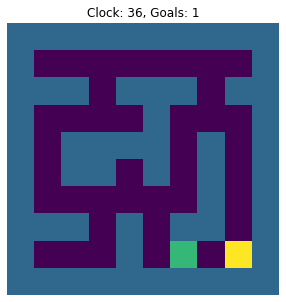

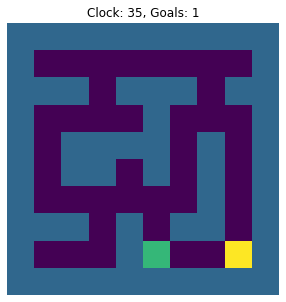

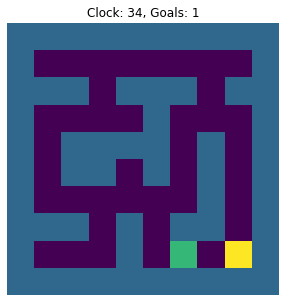

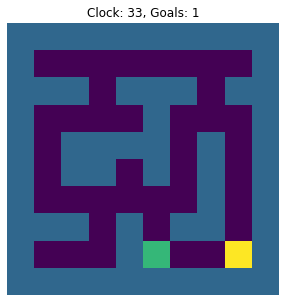

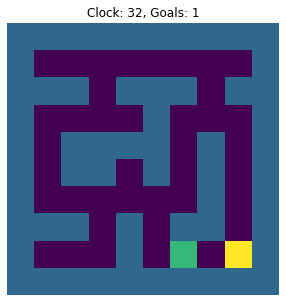

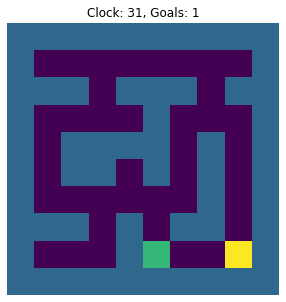

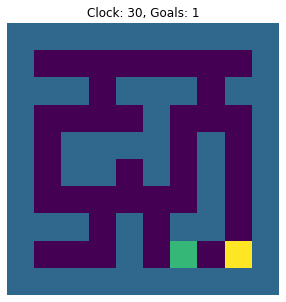

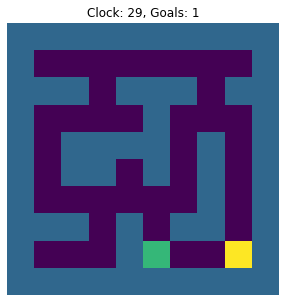

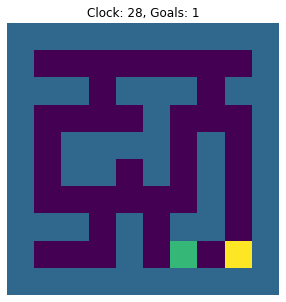

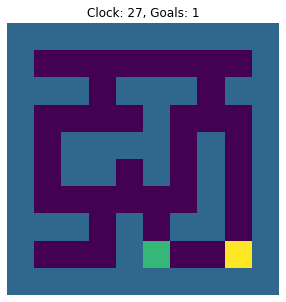

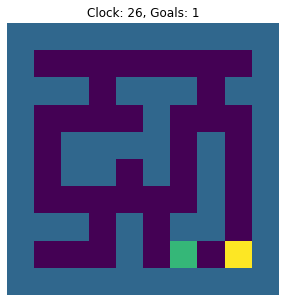

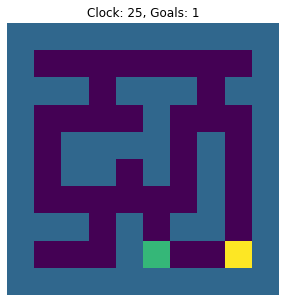

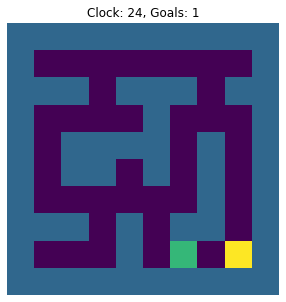

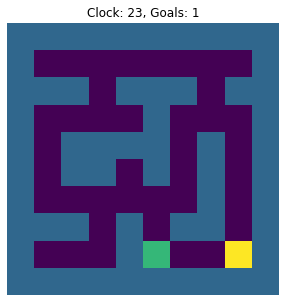

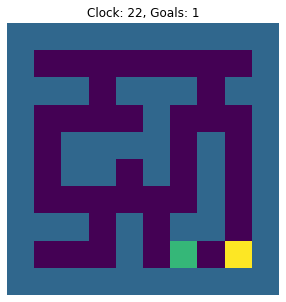

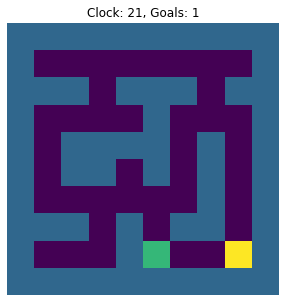

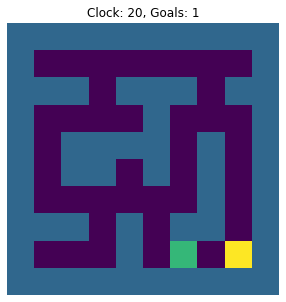

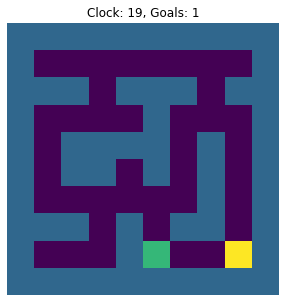

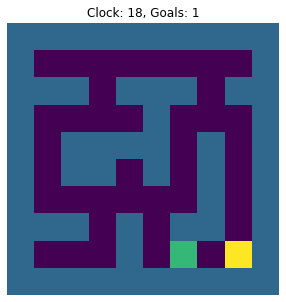

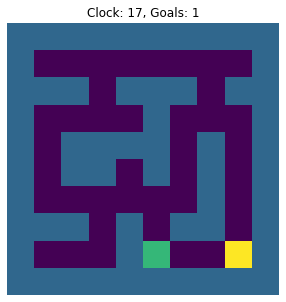

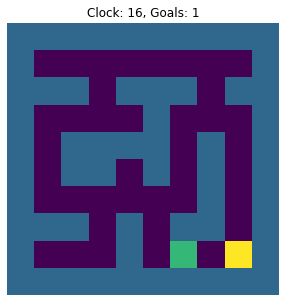

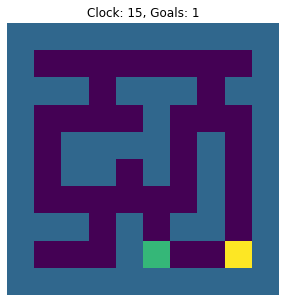

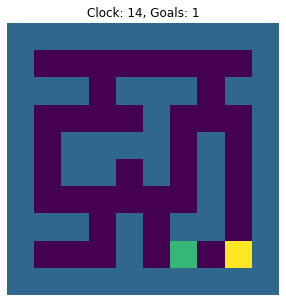

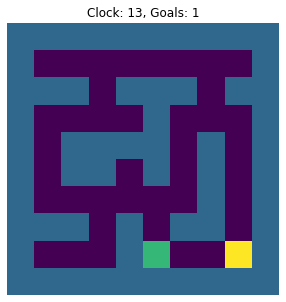

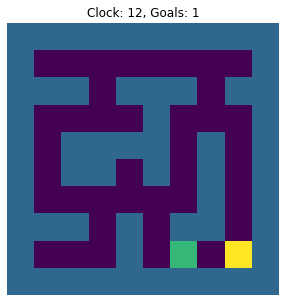

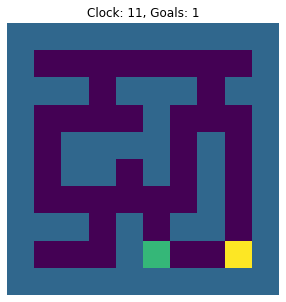

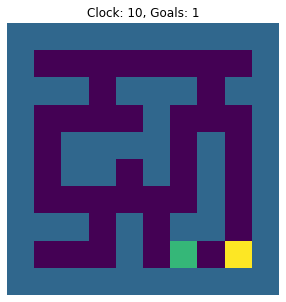

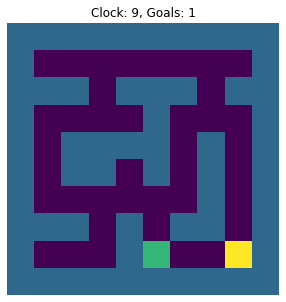

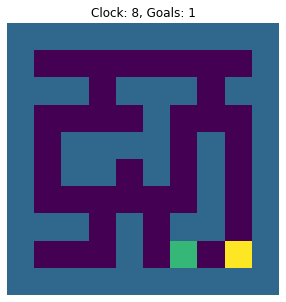

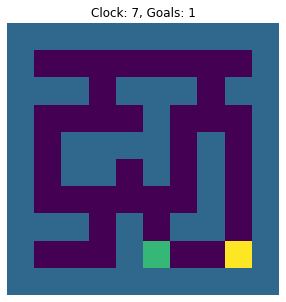

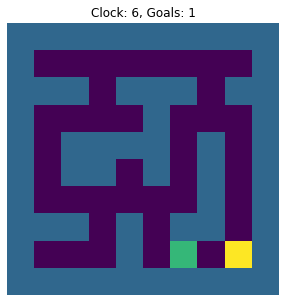

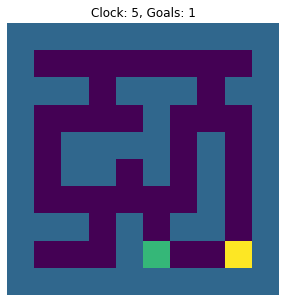

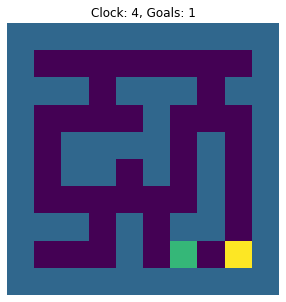

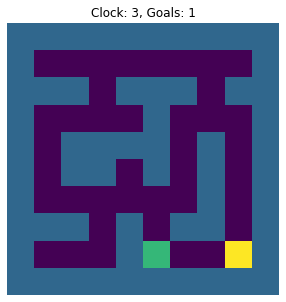

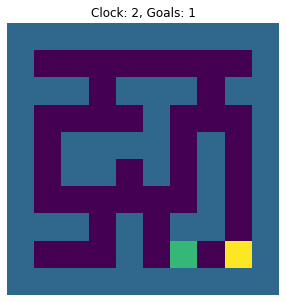

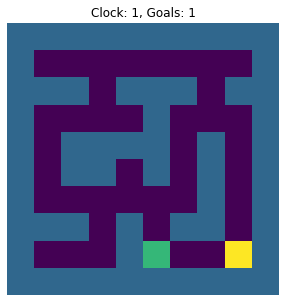

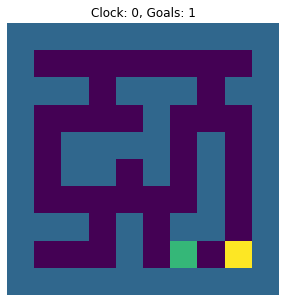

In [16]:
dqn_tester(dqn, 1, True)

# 4. Saving and Reloading Model

In [32]:
dqn.save_weights('saved_models/10x10_maze_easy_redux.h5f', overwrite=False)

In [12]:
del model
del dqn
del env

In [13]:
env = GameEnv()
actions = env.action_space.n
states = env.observation_space.shape
model = build_model(states, actions)
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

In [14]:
dqn.load_weights('saved_models/10x10_maze_easy_redux.h5f')

In [17]:
dqn_tester(dqn, 15)

Testing for 15 episodes ...
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Episode 1: reward: 59.040, steps: 27
Episode 2: reward: 59.040, steps: 27
Episode 3: reward: 59.040, steps: 27
Episode 4: reward: 59.040, steps: 27
Episode 5: reward: 59.040, steps: 27
Episode 6: reward: 59.040, steps: 27
Episode 7: reward: 59.040, steps: 27
Episode 8: reward: 59.040, steps: 27
Episode 9: reward: 59.040, steps: 27
Episode 10: reward: 59.040, steps: 27
Episode 11: reward: 59.040, steps: 27
Episode 12: reward: 59.040, steps: 27
Episode 13: reward: 59.040, steps: 27
Episode 14: reward: 59.040, steps: 27
Episode 15: reward: 59.040, steps: 27
Mean Reward: 59.03999999999999


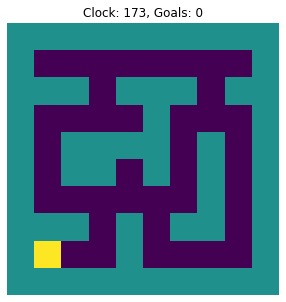

Episode 1: reward: 59.040, steps: 27
Mean Reward: 59.04000000000001


In [19]:
dqn_tester(dqn, 1, True)